<img src="https://sumersports.com/the-zone/_next/image?url=https%3A%2F%2Fcms-cdn.prd.sumersports.com%2FSumerSports_BDB3.jpg&w=1920&q=75" style="width: 300px;" alt="SumerSports logo Image">

# Modeling Player Tracking Data with Transformers for Team Coverage Prediction
*Unlocking deeper football insights through advanced machine learning*

## Overview
This comprehensive notebook demonstrates the application of transformer models to NFL player tracking data for predicting **team coverage** - a binary classification
task to determine if the defensive coverage is Man or Zone. By leveraging state-of-the-art deep learning architectures, we analyze complex player movements to make
binary predictions.

*Note: This notebook is intended as an educational resource to demonstrate transformer applications in sports analytics, not as a competitive entry for the Kaggle
competition. Our goal is to provide a foundation for understanding and implementing these techniques.*

## Why Transformers?
Transformers represent a breakthrough in analyzing spatio-temporal sports data. These powerful models are particularly well-suited for team coverage prediction as they
naturally handle variable player ordering, capture complex interactions between players, and excel at understanding temporal patterns in player movements. Their
self-attention mechanism provides a natural framework for understanding the relationships between all players on the field.

For those more interested in the transformer model, look at Attention is All You Need, for Sports Tracking Data or the workshop we presented at Carnegie Mellon Sports Analytics conference on our public GitHub repository: [SportsTrackingTransformer](https://github.com/SumerSports/SportsTrackingTransformer)
## Contents
1. Data Preprocessing:
   Processing NFL tracking data into a suitable format and selecting relevant features. We'll cover data cleaning, normalization, and the creation of meaningful input
sequences that capture player movements. Due to computational limitations, we process the available data for this notebook.

2. Model Implementation:
   Setting up the transformer architecture and training pipeline using modern deep learning frameworks. In this example we will train models to predict
`team_coverage_man_zone` - a binary classification target (Man Coverage vs Zone Coverage).

3. Analysis & Evaluation:
   Assessing model performance through classification metrics like Accuracy, Precision, Recall, F1-Score, and visualizations showing predictions over time with
animated bar charts.

## Applications
While our focus centers on NFL data, the methodologies and techniques presented here extend far beyond football. These approaches can be adapted for analyzing player
tracking data across various sports including basketball, soccer, hockey, and more.

## Contributing
This notebook represents a collaborative effort to advance the field of sports analytics. We actively encourage community participation through feedback, code
contributions, and discussions about innovative approaches. By sharing knowledge and building upon each other's work, we can collectively push the boundaries of what's
possible in sports analytics.
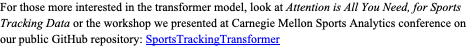
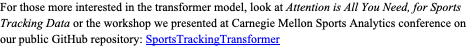
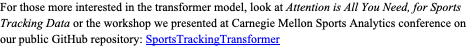
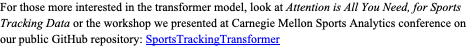

# Step 0: Add "transformerutils" utils via Kaggle Dataset
`File --> Add Input --> DataSets --> Search "transformerutils" --> Add`


In [ ]:
!pip install lightning

In [ ]:
import sys
sys.path.append('/kaggle/input/transformerutils')

# Remove any existing 'datasets' import
if 'datasets' in sys.modules:
    del sys.modules['datasets']

# Put your path FIRST so it takes priority
sys.path.insert(0, '/kaggle/input/transformerutils')

import prep_data
import datasets
import models

# Step 1: Preprocess the Raw Data

Before we can train our models, we need to preprocess the raw NFL tracking data. This involves:

1. **prep_data.main()**: Load and preprocess raw tracking data
   - Load input CSV files from `data/train/`
   - Load supplementary data from `data/supplementary_data.csv` for team_coverage_man_zone labels
   - Convert polar coordinates to Cartesian format
   - Standardize play directions
   - Extract position and kinematic features (x, y, s, a, vx, vy, ox, oy)
   - Extract team_coverage_man_zone classification target from supplementary data
   - Split data into train/val/test sets (70-15-15)

2. **datasets.main()**: Create transformer-ready datasets
   - Pre-compute feature transforms for each frame
   - Package data into efficient pickle files
   - Each sample: 22 players × 8 features, with team_coverage_man_zone target (0/1)

This may take a few minutes to complete.

In [ ]:
prep_data.main()
datasets.main()

# Explore the modeling target -> team_coverage_man_zone

We'll be predicting whether a play is man v. zone or not using a binary classification:
- **team_coverage_man_zone**: Boolean value (True/False or 1/0) indicating if the play involves man coverage (1)

In [ ]:
import pandas as pd
import numpy as np
import polars as pl

# Read the preprocessed target data
try:
    # Try to load from preprocessed data
    target_df = pd.read_parquet('/kaggle/working/split_prepped_data/train_targets.parquet')
    
    if 'team_coverage_man_zone' in target_df.columns:
        print("Man/Zone Statistics:")
        print("=" * 80)
        print(f"\nMan v. Zone distribution:")
        print(target_df['team_coverage_man_zone'].value_counts().sort_index())
        print(f"\n  Total samples:     {len(target_df):,}")
        print(f"  man_zone=1:     {target_df['team_coverage_man_zone'].sum():,} ({100*target_df['team_coverage_man_zone'].mean():.1f}%)")
        print(f"  man_zone=0:     {(~target_df['team_coverage_man_zone'].astype(bool)).sum():,} ({100*(1-target_df['team_coverage_man_zone'].mean()):.1f}%)")
        print("\n" + "=" * 80)
        print("\nNote: team_coverage_man_zone labels are from supplementary_data.csv")
        print("  - team_coverage_man_zone = TRUE/FALSE from actual play metadata")
        print("  - Represents whether the play was man coverage if true")
    else:
        print("⚠️ team_coverage_man_zone column not found in targets. Run preprocessing first.")
    
except FileNotFoundError:
    print("Target data not yet generated. Will be created during preprocessing.")
    print("\nTarget:")
    print("  - team_coverage_man_zone: binary value (0/1)")
    print("  - Real labels from supplementary_data.csv")

# Output dimension for classification (1 value: team_coverage_man_zone probability)
output_dim = 1
print(f"\nModel output dimension: {output_dim} (team_coverage_man_zone probability)")

# 1. Load Preprocessed Data

Now that the data has been preprocessed, we can load the datasets for training.

In [ ]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
from datasets import load_datasets

# Load preprocessed datasets for man v. zone prediction (classification)
# These were already created and pickled by datasets.main()
print("Loading pre-computed datasets from pickle files...")

train_dataset = load_datasets(split='train', target_type='classification')
val_dataset = load_datasets(split='val', target_type='classification')
test_dataset = load_datasets(split='test', target_type='classification')

print("✓ Datasets loaded successfully!")

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Print feature and target shapes from DataLoaders
for batch in train_loader:
   features, targets = batch
   print("\nTrain features shape:", features.shape)
   print("Train targets shape:", targets.shape)
   print(f"\nFeatures: {features.shape[1]} players x {features.shape[2]} features per player")
   print(f"Targets: scalar value (team_coverage_man_zone: 0 or 1)")
   print(f"\nSample targets (first 10): {targets[:10]}")
   break

# 2. Model Implemenation

In [ ]:
from models import LitModel_PA  # Using classification model

# Model parameters for man v. zone prediction (binary classification task)
model_type = "transformer"  # Can be "transformer" or "zoo"
batch_size = 64
model_dim = 64  # Dimension of transformer model (adjustable)
num_layers = 4  # Number of transformer layers (adjustable)
dropout = 0.1
learning_rate = 1e-4

# Initialize the model for binary classification (predicting team_coverage_man_zone)
# Output dimension is 1 (team_coverage_man_zone probability)
model = LitModel_PA(
    model_type=model_type,
    batch_size=batch_size,
    model_dim=model_dim,
    num_layers=num_layers,
    dropout=dropout,
    learning_rate=learning_rate,
)

print(f"Model initialized: {model_type}")
print(f"Output dimension: 1 (team_coverage_man_zone probability)")
print(f"Loss function: BCEWithLogitsLoss (binary classification)")
print(f"Number of parameters: {model.num_params:,}")

In [ ]:
# Import from 'lightning' (not 'pytorch_lightning') to match models.py
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path

# Define checkpointing to save the best model
checkpoint_callback = ModelCheckpoint(
   dirpath=Path("checkpoints/"),
   filename="best-checkpoint",
   save_top_k=1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)

# Define early stopping
early_stop_callback = EarlyStopping(
   monitor="val_loss",
   min_delta=0.01,  # Minimum change in monitored value to qualify as an improvement
   patience=3,      # Number of epochs with no improvement after which training will be stopped
   verbose=True,
   mode="min"
)

# Initialize the trainer
trainer = Trainer(
    max_epochs=20,  # Adjust the number of epochs
    accelerator="gpu",  # Use 'gpu' if CUDA is available, otherwise use 'cpu'
    devices=[0],
    strategy="auto",
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [ ]:
# Start training
trainer.fit(model, train_loader, val_loader)

# 3. Analysis and Evaluation

In [ ]:
# Inference on test data - get man v. zone predictions
predictions = trainer.predict(model, test_loader)
print(f"Generated predictions for {len(test_loader.dataset)} test samples")

In [ ]:
# Concatenate predictions into a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Predictions are probabilities (0-1) for man v. zone
print(f"Predictions shape: {predictions_tensor.shape}")
print(f"Sample predictions (first 10):")
print(predictions_tensor[:10])
print(f"\nPrediction range: [{predictions_tensor.min():.3f}, {predictions_tensor.max():.3f}]")

# Convert to binary predictions (threshold at 0.5)
binary_predictions = (predictions_tensor > 0.5).float()
print(f"\nBinary predictions (first 10): {binary_predictions[:10].int().tolist()}")

In [ ]:
import numpy as np

# Extract true man v. zone labels from the test_loader
y_true = torch.cat([y for _, y in test_loader], dim=0)

# Convert tensors to numpy arrays
y_true_np = y_true.cpu().numpy()
predicted_probs_np = predictions_tensor.cpu().numpy()
predicted_binary_np = binary_predictions.cpu().numpy()

print("Ground truth shape:", y_true_np.shape)
print("Predicted probabilities shape:", predicted_probs_np.shape)
print("Predicted binary shape:", predicted_binary_np.shape)

print(f"\nSample ground truth labels (first 10):")
print(y_true_np[:10].astype(int))
print(f"\nSample predicted probabilities (first 10):")
print(predicted_probs_np[:10])
print(f"\nSample predicted binary labels (first 10):")
print(predicted_binary_np[:10].astype(int))

In [ ]:
# Create a test dataframe with predictions and ground truth
df_test_all = pd.DataFrame({
    'gameId': [key[0] for key in test_dataset.keys],
    'playId': [key[1] for key in test_dataset.keys],
    'frameId': [key[2] for key in test_dataset.keys],
    'team_coverage_man_zone_true': y_true_np.astype(int),
    'team_coverage_man_zone_prob': predicted_probs_np,
    'team_coverage_man_zone_pred': predicted_binary_np.astype(int),
})

print("=" * 80)
print("DATA STRUCTURE ANALYSIS")
print("=" * 80)
print(f"Total test samples (all frames): {len(df_test_all):,}")
print(f"Unique plays: {df_test_all.groupby(['gameId', 'playId']).ngroups:,}")
print(f"Average frames per play: {len(df_test_all) / df_test_all.groupby(['gameId', 'playId']).ngroups:.1f}")

# CLASS DISTRIBUTION
print("\n" + "=" * 80)
print("CLASS DISTRIBUTION")
print("=" * 80)

print(f"\nGround Truth Distribution:")
print(df_test_all['team_coverage_man_zone_true'].value_counts().sort_index())
print(f"  man_zone=1: {df_test_all['team_coverage_man_zone_true'].sum():,} ({100*df_test_all['team_coverage_man_zone_true'].mean():.1f}%)")
print(f"  man_zone=0: {(~df_test_all['team_coverage_man_zone_true'].astype(bool)).sum():,} ({100*(1-df_test_all['team_coverage_man_zone_true'].mean()):.1f}%)")

print(f"\nPredicted Distribution:")
print(df_test_all['team_coverage_man_zone_pred'].value_counts().sort_index())
print(f"  man_zone=1: {df_test_all['team_coverage_man_zone_pred'].sum():,} ({100*df_test_all['team_coverage_man_zone_pred'].mean():.1f}%)")
print(f"  man_zone=0: {(~df_test_all['team_coverage_man_zone_pred'].astype(bool)).sum():,} ({100*(1-df_test_all['team_coverage_man_zone_pred'].mean()):.1f}%)")

# FILTER TO LAST FRAME PER PLAY
print("\n" + "=" * 80)
print("FILTERING TO LAST FRAME PER PLAY")
print("=" * 80)

# Get the last frame_id for each unique (gameId, playId) pair
df_test = df_test_all.loc[df_test_all.groupby(['gameId', 'playId'])['frameId'].idxmax()].reset_index(drop=True)

print(f"✓ Filtered from {len(df_test_all):,} frames to {len(df_test):,} plays (last frame only)")
print(f"✓ This represents {len(df_test):,} unique plays")

# Calculate metrics
df_test['correct'] = (df_test['team_coverage_man_zone_pred'] == df_test['team_coverage_man_zone_true']).astype(int)

print("\n" + "=" * 80)
print("Test predictions dataframe (LAST FRAME PER PLAY):")
print("=" * 80)
display(df_test.head(10))

## Man v. Zone Prediction Analysis

In [ ]:
# Extract values for easier access
true_labels = df_test['team_coverage_man_zone_true'].values
pred_labels = df_test['team_coverage_man_zone_pred'].values
pred_probs = df_test['team_coverage_man_zone_prob'].values
correct = df_test['correct'].values

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification metrics (using LAST FRAME PER PLAY only)
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, zero_division=0)
recall = recall_score(true_labels, pred_labels, zero_division=0)
f1 = f1_score(true_labels, pred_labels, zero_division=0)
cm = confusion_matrix(true_labels, pred_labels)

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Print metrics
print("=" * 80)
print("MAN v. ZONE PREDICTION - CLASSIFICATION METRICS")
print("(Evaluated on LAST FRAME of each play only)")
print("=" * 80)

print(f"\n📊 Evaluation Dataset:")
print(f"  Number of plays evaluated: {len(df_test):,}")
print(f"  (Filtered from {len(df_test_all):,} total frames)")

print("\n📈 Classification Metrics:")
print(f"  Accuracy:   {accuracy:.4f} ({100*accuracy:.2f}%)")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  F1-Score:   {f1:.4f}")
print(f"  ROC AUC:    {roc_auc:.4f}")

print("\n📊 Confusion Matrix:")
print(f"                Predicted")
print(f"              0       1")
print(f"  Actual 0   {cm[0][0]:4d}   {cm[0][1]:4d}")
print(f"         1   {cm[1][0]:4d}   {cm[1][1]:4d}")

print("\n" + "=" * 80)
print("\nDetailed Classification Report:")
print("=" * 80)
print(classification_report(true_labels, pred_labels, target_names=['ZONE Coverage', 'MAN Coverage']))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
           xticklabels=['Zone', 'Man'], yticklabels=['Zone', 'Man'])
axes[0, 0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'Confusion Matrix\n(Accuracy: {accuracy:.2%})', 
                    fontsize=13, fontweight='bold')

# ROC Curve
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_title('ROC Curve (Last Frame Per Play)', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Prediction Probability Distribution
axes[1, 0].hist(pred_probs[true_labels == 0], bins=50, alpha=0.6, label='Zone (Man)', color='blue', edgecolor='black')
axes[1, 0].hist(pred_probs[true_labels == 1], bins=50, alpha=0.6, label='Man (Man)', color='red', edgecolor='black')
axes[1, 0].axvline(0.5, color='green', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1, 0].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Prediction Probability Distribution', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bar chart of metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc]
colors = ['blue' if v >= 0.7 else 'orange' if v >= 0.5 else 'red' for v in metrics_values]

bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Classification Metrics Summary', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim(0, 1.0)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{value:.3f}',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Show example plays with predictions (last frame per play)
# Select a few interesting plays to visualize
sample_plays = df_test.sample(10)

print("Sample predictions (LAST FRAME PER PLAY):")
print("=" * 80)
for idx, row in sample_plays.iterrows():
    print(f"\nPlay: Game {int(row['gameId'])}, Play {int(row['playId'])}, Frame {int(row['frameId'])} (LAST)")
    print(f"  True Label:         {int(row['team_coverage_man_zone_true'])} ({'Man' if row['team_coverage_man_zone_true'] else 'Zone'})")
    print(f"  Predicted Prob:     {row['team_coverage_man_zone_prob']:.4f}")
    print(f"  Predicted Label:    {int(row['team_coverage_man_zone_pred'])} ({'Man' if row['team_coverage_man_zone_pred'] else 'Zone'})")
    print(f"  Correct:            {'✓' if row['correct'] else '✗'}")
print("=" * 80)

In [ ]:
import pandas as pd
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def animate_play_with_mz_prediction(
    df_test_all: pd.DataFrame,
    test_dataset,
    gameId: int,
    playId: int,
):
    """
    Animate a play showing player positions on the field with man v. zone prediction bar chart at top.
    
    Features:
    - Top subplot: Animated bar chart showing man v. zone probability for current frame
    - Bottom subplot: Football field with player tracking data, yard markers, and field decorations
    
    Args:
        df_test_all: DataFrame with all frame predictions (gameId, playId, frameId, team_coverage_man_zone_prob, etc.)
        test_dataset: Dataset object with tracking data
        gameId: Game ID to animate
        playId: Play ID to animate
        
    Returns:
        plotly Figure object with animation, or None if data not found
    """
    # Filter predictions for this play
    play_preds = df_test_all[
        (df_test_all['gameId'] == gameId) & 
        (df_test_all['playId'] == playId)
    ].sort_values('frameId').reset_index(drop=True)
    
    if len(play_preds) == 0:
        print(f"❌ No predictions found for Game {gameId}, Play {playId}")
        return None
    
    # Load tracking data for this play
    tracking_data = []
    for i in range(len(test_dataset)):
        key = test_dataset.keys[i]
        if key[0] == gameId and key[1] == playId:
            # Get features which are player positions (22 players x 8 features)
            # Note: nfl_id is in the index, so we need to reset_index() to get it as a column
            features = test_dataset.feature_df_partition.loc[(gameId, playId, key[2])].reset_index()
            features['frameId'] = key[2]
            tracking_data.append(features)
    
    if len(tracking_data) == 0:
        print(f"❌ No tracking data found for Game {gameId}, Play {playId}")
        return None
    
    # Merge tracking and prediction data
    tracking_df = pd.concat(tracking_data, ignore_index=True).reset_index(drop=True)
    tracking_df = tracking_df.merge(
        play_preds[['frameId', 'team_coverage_man_zone_prob', 'team_coverage_man_zone_pred', 'team_coverage_man_zone_true']], 
        on='frameId', 
        how='left'
    )
    
    # Get play info
    true_label = play_preds['team_coverage_man_zone_true'].iloc[0]
    final_pred = play_preds['team_coverage_man_zone_pred'].iloc[-1]
    final_prob = play_preds['team_coverage_man_zone_prob'].iloc[-1]
    
    # Prepare data for animation
    tracking_df['displayName'] = 'Player ' + tracking_df['nfl_id'].astype(str)
    # FIX: Convert to lowercase first, then map (player_side comes as 'Offense'/'Defense')
    tracking_df['side'] = tracking_df['player_side'].str.lower().map({'offense': 'OFF', 'defense': 'DEF'})
    tracking_df['jerseyNumber'] = ''
    
    # Get field bounds
    y_min = max(0, tracking_df['x'].min() - 10)
    y_max = min(120, tracking_df['x'].max() + 10)
    
    # Create figure with subplots: bar chart at top, field at bottom  
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.2, 0.8],
        specs=[[{"type": "bar"}], [{"type": "scatter"}]],
        vertical_spacing=0.08,
        subplot_titles=(
            f"<b>Man v Zone Probability (Frame-by-Frame)</b>",
            f"<b>Game {gameId} | Play {playId} | Ground Truth: {'MAN Coverage' if true_label else 'ZONE Coverage'} | "
            f"Final Prediction: {'MAN Coverage' if final_pred else 'ZONE Coverage'} ({final_prob:.1%})</b>"
        )
    )
    
    # Field dimensions
    X_LEFT = 0
    X_RIGHT = 160 / 3.0  # ~53.3 yards (field width)
    X_MIDDLE = X_RIGHT / 2
    Y_MIN = 0
    Y_MAX = 120
    
    # Get unique frames
    unique_frames = sorted(tracking_df['frameId'].unique())
    
    # Initialize with first frame data
    first_frame = tracking_df[tracking_df['frameId'] == unique_frames[0]]
    first_prob = first_frame['team_coverage_man_zone_prob'].iloc[0]
    
    # Add initial bar chart trace
    fig.add_trace(
        go.Bar(
            x=['Zone Coverage', 'Man Coverage'],
            y=[1 - first_prob, first_prob],
            marker=dict(
                color=['#3498db', '#e74c3c'],
                line=dict(color='white', width=2)
            ),
            text=[f"{(1-first_prob):.1%}", f"{first_prob:.1%}"],
            textposition='outside',
            textfont=dict(size=14, color='white', family='Arial Black'),
            showlegend=False,
            hovertemplate='<b>%{x}</b><br>Probability: %{y:.1%}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add initial player positions for offense
    off_data = first_frame[first_frame['side'] == 'OFF']
    fig.add_trace(
        go.Scatter(
            x=off_data['y'],
            y=off_data['x'],
            mode='markers+text',
            marker=dict(
                size=13,
                color='#39FF14',
                line=dict(width=2, color='white'),
                opacity=0.9
            ),
            text=off_data['jerseyNumber'],
            textfont=dict(size=10, color='black', family='Arial Black'),
            textposition='middle center',
            hovertext=off_data['displayName'],
            hovertemplate='<b>%{hovertext}</b><br>X: %{y:.1f}<br>Y: %{x:.1f}<extra></extra>',
            showlegend=False,
            name='OFF'
        ),
        row=2, col=1
    )
    
    # Add initial player positions for defense
    def_data = first_frame[first_frame['side'] == 'DEF']
    fig.add_trace(
        go.Scatter(
            x=def_data['y'],
            y=def_data['x'],
            mode='markers+text',
            marker=dict(
                size=13,
                color='#FF69B4',
                line=dict(width=2, color='white'),
                opacity=0.9
            ),
            text=def_data['jerseyNumber'],
            textfont=dict(size=10, color='black', family='Arial Black'),
            textposition='middle center',
            hovertext=def_data['displayName'],
            hovertemplate='<b>%{hovertext}</b><br>X: %{y:.1f}<br>Y: %{x:.1f}<extra></extra>',
            showlegend=False,
            name='DEF'
        ),
        row=2, col=1
    )
    
    # Add field markings (these are static, not part of animation)
    # Field border
    fig.add_shape(
        type="rect", x0=X_LEFT, y0=Y_MIN, x1=X_RIGHT, y1=Y_MAX,
        line=dict(color="rgba(255, 255, 255, 0.6)", width=4),
        row=2, col=1
    )
    
    # Add yard lines and markers
    for y_loc in range(Y_MIN + 10, Y_MAX - 10 + 1, 1):
        if y_loc % 10 == 0:
            # Major yard line (every 10 yards)
            ydln = y_loc - 10 if y_loc <= 60 else 110 - y_loc
            ydln_txt = str(ydln) if ydln != 0 else "EZ"
            
            fig.add_shape(
                type="line", x0=X_LEFT, y0=y_loc, x1=X_RIGHT, y1=y_loc,
                line=dict(color="white", width=2), opacity=0.1,
                row=2, col=1
            )
            
            # Yard markers on left
            fig.add_annotation(
                x=X_LEFT + 4, y=y_loc,
                text=ydln_txt,
                showarrow=False,
                font=dict(color="white", size=50, family='Arial Black'),
                textangle=90,
                opacity=0.08,
                row=2, col=1
            )
            
            # Yard markers on right
            fig.add_annotation(
                x=X_RIGHT - 4, y=y_loc,
                text=ydln_txt,
                showarrow=False,
                font=dict(color="white", size=50, family='Arial Black'),
                textangle=270,
                opacity=0.08,
                row=2, col=1
            )
        elif y_loc % 5 == 0:
            # Minor yard line (every 5 yards)
            fig.add_shape(
                type="line", x0=X_LEFT, y0=y_loc, x1=X_RIGHT, y1=y_loc,
                line=dict(color="white", width=1), opacity=0.06,
                row=2, col=1
            )
        else:
            # Hash marks
            fig.add_shape(
                type="rect",
                x0=X_MIDDLE - 9.5, y0=y_loc, x1=X_MIDDLE - 8.5, y1=y_loc,
                line=dict(color="white", width=2), opacity=0.05,
                row=2, col=1
            )
            fig.add_shape(
                type="rect",
                x0=X_MIDDLE + 9.5, y0=y_loc, x1=X_MIDDLE + 8.5, y1=y_loc,
                line=dict(color="white", width=2), opacity=0.05,
                row=2, col=1
            )
    
    # End zones
    fig.add_shape(
        type="rect", x0=X_LEFT, y0=Y_MAX - 10, x1=X_RIGHT, y1=Y_MAX,
        fillcolor="rgba(57, 255, 20, 0.1)",
        line=dict(color="#39FF14", width=3),
        row=2, col=1
    )
    fig.add_shape(
        type="rect", x0=X_LEFT, y0=Y_MIN, x1=X_RIGHT, y1=Y_MIN + 10,
        fillcolor="rgba(255, 105, 180, 0.1)",
        line=dict(color="#FF69B4", width=3),
        row=2, col=1
    )
    
    # Create animation frames - update the actual data for each frame
    frames = []
    
    for frame_id in unique_frames:
        frame_data = tracking_df[tracking_df['frameId'] == frame_id]
        current_prob = frame_data['team_coverage_man_zone_prob'].iloc[0]
        current_pred = frame_data['team_coverage_man_zone_pred'].iloc[0]
        
        # Get offense and defense data for this frame
        off_data = frame_data[frame_data['side'] == 'OFF']
        def_data = frame_data[frame_data['side'] == 'DEF']
        
        # Create frame with updated data for all three traces
        frames.append(go.Frame(
            data=[
                # Update bar chart (trace 0)
                go.Bar(
                    x=['Zone Coverage', 'Man Coverage'],
                    y=[1 - current_prob, current_prob],
                    marker=dict(
                        color=['#3498db', '#e74c3c'],
                        line=dict(color='white', width=2)
                    ),
                    text=[f"{(1-current_prob):.1%}", f"{current_prob:.1%}"],
                    textposition='outside',
                    textfont=dict(size=14, color='white', family='Arial Black'),
                ),
                # Update offense positions (trace 1)
                go.Scatter(
                    x=off_data['y'],
                    y=off_data['x'],
                    mode='markers+text',
                    marker=dict(size=13, color='#39FF14', line=dict(width=2, color='white'), opacity=0.9),
                    text=off_data['jerseyNumber'],
                    textfont=dict(size=10, color='black', family='Arial Black'),
                    hovertext=off_data['displayName'],
                ),
                # Update defense positions (trace 2)
                go.Scatter(
                    x=def_data['y'],
                    y=def_data['x'],
                    mode='markers+text',
                    marker=dict(size=13, color='#FF69B4', line=dict(width=2, color='white'), opacity=0.9),
                    text=def_data['jerseyNumber'],
                    textfont=dict(size=10, color='black', family='Arial Black'),
                    hovertext=def_data['displayName'],
                ),
            ],
            name=str(frame_id),
            layout=go.Layout(
                title=dict(
                    text=f"<b>Frame {frame_id} | PA Probability: {current_prob:.1%} | "
                         f"Prediction: {'MAN' if current_pred else 'ZONE'}</b>",
                    x=0.5,
                    xanchor='center'
                )
            )
        ))
    
    # Update layout for bar chart
    fig.update_xaxes(title_text="", showgrid=False, row=1, col=1)
    fig.update_yaxes(title_text="Probability", range=[0, 1.15], showgrid=True, 
                     gridcolor='rgba(255, 255, 255, 0.1)', row=1, col=1)
    
    # Update layout for field
    fig.update_xaxes(title_text="", range=[X_LEFT - 2, X_RIGHT + 2], showgrid=False, 
                     zeroline=False, showticklabels=False, row=2, col=1)
    fig.update_yaxes(title_text="", range=[y_min, y_max], showgrid=False, 
                     zeroline=False, showticklabels=False, row=2, col=1)
    
    # Set aspect ratio for field
    fig.update_yaxes(scaleanchor="x", scaleratio=1, row=2, col=1)
    
    # Overall layout
    fig.update_layout(
        height=1000,
        width=1100,
        paper_bgcolor='#2c3e50',
        plot_bgcolor='#34495e',
        font=dict(color='white', size=13, family='Arial'),
        title=dict(
            text=f"<b>Man v. Zone Prediction Analysis</b>",
            x=0.5,
            xanchor='center',
            font=dict(size=18)
        ),
        updatemenus=[{
            'type': 'buttons',
            'direction': 'left',
            'buttons': [
                {
                    'label': '▶ Play',
                    'method': 'animate',
                    'args': [None, {
                        'frame': {'duration': 150, 'redraw': True},
                        'fromcurrent': True,
                        'mode': 'immediate',
                        'transition': {'duration': 50}
                    }]
                },
                {
                    'label': '⏸ Pause',
                    'method': 'animate',
                    'args': [[None], {
                        'frame': {'duration': 0, 'redraw': False},
                        'mode': 'immediate',
                        'transition': {'duration': 0}
                    }]
                }
            ],
            'x': 0.12,
            'y': 1.02,
            'xanchor': 'left',
            'yanchor': 'top',
            'bgcolor': 'rgba(255, 255, 255, 0.2)',
            'bordercolor': 'white',
            'borderwidth': 2
        }],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'y': -0.02,
            'xanchor': 'left',
            'currentvalue': {
                'prefix': 'Frame: ',
                'visible': True,
                'xanchor': 'center',
                'font': {'size': 14, 'color': 'white'}
            },
            'pad': {'b': 10, 't': 10},
            'len': 0.9,
            'x': 0.05,
            'steps': [
                {
                    'label': str(f),
                    'method': 'animate',
                    'args': [[str(f)], {
                        'frame': {'duration': 150, 'redraw': True},
                        'mode': 'immediate',
                        'transition': {'duration': 50}
                    }]
                }
                for f in unique_frames
            ],
            'bgcolor': 'rgba(255, 255, 255, 0.2)',
            'bordercolor': 'white',
            'borderwidth': 2,
            'tickcolor': 'white'
        }]
    )
    
    fig.frames = frames
    
    print(f"✓ Animation created successfully!")
    print(f"  Frames: {len(unique_frames)}")
    print(f"  Players per frame: {len(off_data) + len(def_data)} ({len(off_data)} OFF, {len(def_data)} DEF)")
    print(f"  Ground Truth: {'MAN Coverage' if true_label else 'ZONE Coverage'}")
    print(f"  Final Prediction: {'MAN Coverage' if final_pred else 'ZONE Coverage'} ({final_prob:.1%})")
    
    return fig



# 4. Animate Man v. Zone Predictions

Now let's visualize how the model's man v. zone predictions change over time during a play. The animation shows:
- **Top chart**: Bar chart showing the current probability for each class (ZONE vs MAN)
- **Bottom chart**: Line graph showing how the man v. zone probability evolves frame-by-frame

In [ ]:
# Select a random play from the test set to animate
pl.set_random_seed(67)

sample_play = df_test.sample(1).iloc[0]
gameId = int(sample_play['gameId'])
playId = int(sample_play['playId'])

print(f"Animating play: Game {gameId}, Play {playId}")
print(f"True Label: {'MAN' if sample_play['team_coverage_man_zone_true'] else 'ZONE'}")
print(f"Final Prediction: {'MAN' if sample_play['team_coverage_man_zone_pred'] else 'ZONE'} ({sample_play['team_coverage_man_zone_prob']:.2%})")
print("\nCreating animation...")

# Create and display the animation with player positions and probability bar chart
fig = animate_play_with_mz_prediction(df_test_all, test_dataset, gameId=gameId, playId=playId)

fig.show()